In [74]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC


In [64]:
sofi = pd.read_csv('SOFI.csv') 

Train Test Split Function

In [65]:
def train_test_split_macd(df):

    # Define the training and trading periods
    train_start, train_end = '2024-01-17', '2024-02-29'
    trade_start, trade_end = '2024-03-01', '2025-01-16'

    # Filter the dataset for the training and trading periods
    df_train = df[(df['Date'] >= train_start) & (df['Date'] <= train_end)].copy()
    df_trade = df[(df['Date'] >= trade_start) & (df['Date'] <= trade_end)].copy()

    return df_train, df_trade

MACD Strategy 

In [66]:
def calculate_macd(df):
    """
    Computes the MACD and Signal Line using fixed window sizes.
    Short EMA: 12 periods
    Long EMA: 26 periods
    Signal Line: 9 periods
    """
    df['EMA_Short'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_Long'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_Short'] - df['EMA_Long']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    return df

def macd_strategy_return(df):
    """
    Implements a MACD-based trading strategy with dividend reinvestment.
    """
    df = calculate_macd(df)

    # Set trading positions based on MACD crossover
    df['Position'] = 0.0
    df.loc[df['MACD'] > df['Signal'], 'Position'] = 1.0  # Buy when MACD crosses above Signal
    df.loc[df['MACD'] < df['Signal'], 'Position'] = -0.5  # Short when MACD crosses below Signal

    # Shift positions to avoid lookahead bias
    df['Position'] = df['Position'].shift(1, fill_value=0.0)

    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change()

    # Ensure Dividends column exists and is numeric
    df['Dividends'] = pd.to_numeric(df.get('Dividends', 0), errors='coerce').fillna(0.0)

    # Adjust for reinvested dividends
    df['DividendsAdjustment'] = df['Position'] * (df['Dividends'] / df['Close'])

    # Compute total strategy returns (price + reinvested dividends)
    df['StrategyReturns'] = (df['Position'] * df['Returns']) + df['DividendsAdjustment']

    # Compute cumulative returns
    df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod() - 1 

    best_return_macd = df['CumulativeReturns'].iloc[-1]

    return  best_return_macd




RSI Strategy

In [67]:
def calculate_rsi(df, window=14):
    """
    Calculates the Relative Strength Index (RSI) for a given window size.
    """
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    
    # Compute price changes
    delta = df['Close'].diff()
    
    # Compute gains and losses
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    # Convert to pandas Series to apply rolling mean
    gain_series = pd.Series(gain, index=df.index)
    loss_series = pd.Series(loss, index=df.index)

    # Ensure rolling mean does not produce NaNs
    avg_gain = gain_series.rolling(window=window, min_periods=window).mean()
    avg_loss = loss_series.rolling(window=window, min_periods=window).mean()

    # Avoid division by zero
    rs = avg_gain / (avg_loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    return df

def rsi_strategy_return(df, window=14):
    df = calculate_rsi(df, window)

    # Define fixed RSI thresholds
    lower_rsi = 30
    upper_rsi = 70

    # Set trading positions
    df['Position'] = 0.0
    df.loc[df['RSI'] < lower_rsi, 'Position'] = 1.0  # Buy when RSI is below 30
    df.loc[df['RSI'] > upper_rsi, 'Position'] = -0.5  # Short when RSI is above 70


    # Shift positions to avoid lookahead bias
    df['Position'] = df['Position'].shift(1, fill_value=0.0)

    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change()

    # Ensure Dividends column exists
    df['Dividends'] = pd.to_numeric(df.get('Dividends', 0), errors='coerce').fillna(0.0)

    # Adjust for reinvested dividends
    df['DividendsAdjustment'] = df['Position'] * (df['Dividends'] / df['Close'])

    # Compute total strategy returns (price + reinvested dividends)
    df['StrategyReturns'] = (df['Position'] * df['Returns']) + df['DividendsAdjustment']


    # Compute cumulative returns
    df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod() - 1


    return df['CumulativeReturns'].iloc[-1] if not df.empty else 0.0

def optimize_rsi_window(df):
    """
    Optimizes RSI strategy by finding the best RSI window size (fixed thresholds 30, 70).
    """
    def objective(window):
        window = int(window[0])  # Ensure window is an integer
        if window < 5 or window > 50:
            return -np.inf  # Invalid parameters

        return -rsi_strategy_return(df, window)  # Minimize negative return

    # Define parameter bounds (only optimizing RSI window size)
    bounds = [(5, 50)]  # RSI window range

    # Initial guess
    initial_guess = [14]

    # Optimize using 'Nelder-Mead'
    result = minimize(objective, initial_guess, bounds=bounds, method='Nelder-Mead')

    best_window = int(result.x[0])
    best_return_rsi = -result.fun  # Since we minimized the negative return

    return best_window, best_return_rsi



SMA Strategy

In [68]:
def calculate_sma(df, short_window=50, long_window=200):
    """
    Computes the Simple Moving Averages (SMA).
    """
    df['SMA_Short'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    return df

def sma_strategy_return(df, short_window=50, long_window=200):
    """
    Implements a Simple Moving Average (SMA) crossover trading strategy.
    """
    df = calculate_sma(df, short_window, long_window)

    # Define trading positions
    df['Position'] = 0.0
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Position'] = 1.0  # Buy Signal (Golden Cross)
    df.loc[df['SMA_Short'] < df['SMA_Long'], 'Position'] = -0.5  # Short Signal (Death Cross)

    # Shift positions to avoid lookahead bias
    df['Position'] = df['Position'].shift(1, fill_value=0.0)

    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change()

    # Ensure Dividends column exists
    df['Dividends'] = pd.to_numeric(df.get('Dividends', 0), errors='coerce').fillna(0.0)

    # Adjust for reinvested dividends
    df['DividendsAdjustment'] = df['Position'] * (df['Dividends'] / df['Close'])

    # Compute total strategy returns (price + reinvested dividends)
    df['StrategyReturns'] = (df['Position'] * df['Returns']) + df['DividendsAdjustment']

    # Compute cumulative returns
    df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod() - 1

    return df['CumulativeReturns'].iloc[-1] if not df.empty else 0.0

def optimize_sma_strategy(df):
    """
    Optimizes SMA trading strategy by finding the best short and long moving average window sizes.
    """
    def objective(params):
        short_window, long_window = int(params[0]), int(params[1])
        if short_window >= long_window or short_window < 5 or long_window > 300:
            return -np.inf  # Invalid parameters

        return -sma_strategy_return(df, short_window, long_window)  # Minimize negative return

    # Define parameter bounds
    bounds = [(5, 50),   # Short SMA range
              (100, 300)]  # Long SMA range

    # Initial guess
    initial_guess = [20, 200]

    # Optimize using 'Nelder-Mead'
    result = minimize(objective, initial_guess, bounds=bounds, method='Nelder-Mead')

    best_short_window, best_long_window = int(result.x[0]), int(result.x[1])
    best_return = -result.fun  # Since we minimized the negative return

    return best_short_window, best_long_window, best_return

Logistic Regression Strategy

Dataset Range: 2024-01-22 00:00:00 to 2025-01-16 00:00:00
Dataset Date Range: 2024-01-22 00:00:00 to 2025-01-16 00:00:00
Training Data Rows: 28
Selected Features: ['KDJ_K', 'KDJ_D', 'SMA_Short', 'SMA_Long', 'EMA', 'SMA_EMA_Ratio', 'Aroon_Up', 'ADX', 'Chaikin']


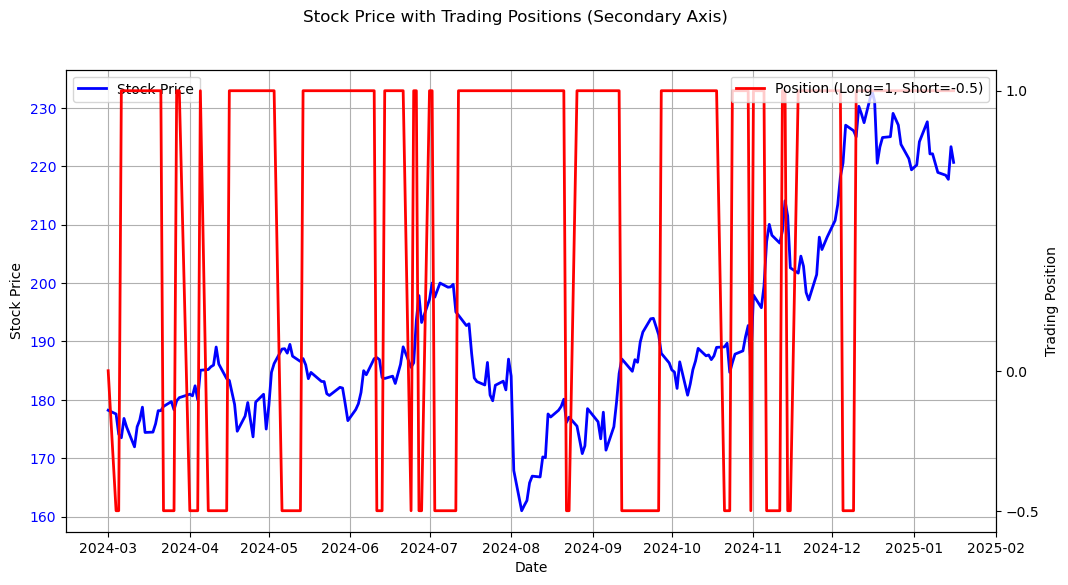

Final Strategy Return: 46.44%


In [69]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector

def calculate_indicators(df):
    """
    Manually computes technical indicators and adds them to the dataframe.
    """
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Relative Strength Index (RSI)
    window = 14
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / (avg_loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    # Stochastic KDJ Indicator
    low_min = df['Low'].rolling(window=14, min_periods=1).min()
    high_max = df['High'].rolling(window=14, min_periods=1).max()
    df['KDJ_K'] = 100 * (df['Close'] - low_min) / (high_max - low_min + 1e-10)
    df['KDJ_D'] = df['KDJ_K'].rolling(window=3, min_periods=1).mean()

    # Moving Averages
    df['SMA_Short'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['SMA_Long'] = df['Close'].rolling(window=14, min_periods=1).mean()
    df['EMA'] = df['Close'].ewm(span=14, adjust=False).mean()
    df['SMA_EMA_Ratio'] = df['SMA_Short'] / (df['EMA'] + 1e-10)

    # On Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # Aroon Up & Aroon Down
    df['Aroon_Up'] = df['High'].rolling(window=14, min_periods=1).apply(lambda x: np.argmax(x) / 14 * 100)
    df['Aroon_Down'] = df['Low'].rolling(window=14, min_periods=1).apply(lambda x: np.argmin(x) / 14 * 100)

    # Average Directional Index (ADX)
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['Low-Close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TrueRange'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df['ATR'] = df['TrueRange'].rolling(window=14, min_periods=1).mean()
    df['ADX'] = 100 * (df['ATR'] / (df['Close'] + 1e-10))

    # Chaikin Oscillator
    money_flow_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'] + 1e-10)
    money_flow_volume = money_flow_multiplier * df['Volume']
    df['Chaikin'] = money_flow_volume.rolling(window=3, min_periods=1).sum()

    # Commodity Channel Index (CCI)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = typical_price.rolling(window=14, min_periods=1).mean()
    mean_deviation = (typical_price - sma_tp).abs().rolling(window=14, min_periods=1).mean()
    df['CCI'] = (typical_price - sma_tp) / (0.015 * mean_deviation + 1e-10)

    return df

def trading_strategy(df):
    """
    Predicts stock movement using logistic regression and applies a trading strategy.
    """
    df = calculate_indicators(df)

    # Ensure DateTime format
    df.index = pd.to_datetime(df.index)

    # Debug: Print dataset range
    print(f"Dataset Date Range: {df.index.min()} to {df.index.max()}")

    # Fill missing values
    df.ffill(inplace=True)

    # Define training and trading periods
    train_start, train_end = '2024-01-01', '2024-02-29'  # Expanded training period
    trade_start, trade_end = '2024-03-01', '2025-01-16'

    # Debug: Check available data
    df_train = df.loc[train_start:train_end].copy()
    df_trade = df.loc[trade_start:trade_end].copy()

    print(f"Training Data Rows: {df_train.shape[0]}")  # Debugging output
    if df_train.shape[0] == 0:
        print("⚠ Error: No data in training period. Try expanding the range.")
        return 0.0

    # Define target variable (1 if stock goes up, 0 if it goes down)
    df_train['Target'] = (df_train['Close'].shift(-1) > df_train['Close']).astype(int)

    # Features for model training
    features = ['RSI', 'KDJ_K', 'KDJ_D', 'SMA_Short', 'SMA_Long', 'EMA', 'SMA_EMA_Ratio',
                'OBV', 'Aroon_Up', 'Aroon_Down', 'ADX', 'Chaikin', 'CCI']
    
    X_train = df_train[features]
    y_train = df_train['Target']

    # Remove constant features and fill NaNs
    X_train = X_train.loc[:, X_train.nunique() > 1]
    X_train.fillna(X_train.mean(), inplace=True)

    # Stepwise feature selection using SFS
    model = LogisticRegression(max_iter=1000)
    sfs = SequentialFeatureSelector(model, n_features_to_select=9, direction='forward')
    sfs.fit(X_train, y_train)
    selected_features = X_train.columns[sfs.get_support()].tolist()

    print(f"Selected Features: {selected_features}")

    # Train logistic regression model
    model.fit(X_train[selected_features], y_train)

    # Apply model on trading period
    df_trade['Predicted'] = model.predict(df_trade[selected_features])

    # Trading strategy: Long (1.0) when predicting up, Short (-0.5) otherwise
    df_trade['Position'] = df_trade['Predicted'].replace({0: -0.5, 1: 1.0}).shift(1, fill_value=0.0)

    # Compute returns
    df_trade['Returns'] = df_trade['Close'].pct_change()
    df_trade['StrategyReturns'] = df_trade['Position'] * df_trade['Returns']
    df_trade['CumulativeReturns'] = (1 + df_trade['StrategyReturns']).cumprod() - 1 

    plot_stock_and_positions(df_trade)

    return df_trade['CumulativeReturns'].iloc[-1]  

def plot_stock_and_positions(df_trade):
    """
    Plots the stock price on the primary y-axis and trading positions on the secondary y-axis.
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Primary y-axis (Stock Price)
    ax1.plot(df_trade.index, df_trade['Close'], label='Stock Price', color='blue', linewidth=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Price')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Secondary y-axis (Trading Position)
    ax2 = ax1.twinx()
    ax2.plot(df_trade.index, df_trade['Position'], label='Position (Long=1, Short=-0.5)', color='red', linewidth=2)
    ax2.set_ylabel('Trading Position')
    ax2.set_yticks([-0.5, 0, 1])  # Ensure only relevant positions are displayed
    ax2.tick_params(axis='y', labelcolor='black')

    # Labels and title
    fig.suptitle('Stock Price with Trading Positions (Secondary Axis)')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True)

    # Show plot
    plt.show()


# Example Usage
df = pd.read_csv('SOFI.csv', index_col='Date', parse_dates=True)

# Debug: Check if dataset has enough data
print(f"Dataset Range: {df.index.min()} to {df.index.max()}")
df = df.dropna(subset=['Close'])

# Apply the trading strategy
final_return = trading_strategy(df)
print(f"Final Strategy Return: {final_return:.2%}")




SVM Strategy

In [ ]:
def calculate_indicators(df):
    """
    Manually computes technical indicators and adds them to the dataframe.
    """
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Relative Strength Index (RSI)
    window = 14
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / (avg_loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    # Stochastic KDJ Indicator
    low_min = df['Low'].rolling(window=14, min_periods=1).min()
    high_max = df['High'].rolling(window=14, min_periods=1).max()
    df['KDJ_K'] = 100 * (df['Close'] - low_min) / (high_max - low_min + 1e-10)
    df['KDJ_D'] = df['KDJ_K'].rolling(window=3, min_periods=1).mean()

    # Moving Averages
    df['SMA_Short'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['SMA_Long'] = df['Close'].rolling(window=14, min_periods=1).mean()
    df['EMA'] = df['Close'].ewm(span=14, adjust=False).mean()
    df['SMA_EMA_Ratio'] = df['SMA_Short'] / (df['EMA'] + 1e-10)

    # On Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # Aroon Up & Aroon Down
    df['Aroon_Up'] = df['High'].rolling(window=14, min_periods=1).apply(lambda x: np.argmax(x) / 14 * 100)
    df['Aroon_Down'] = df['Low'].rolling(window=14, min_periods=1).apply(lambda x: np.argmin(x) / 14 * 100)

    # Average Directional Index (ADX)
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['Low-Close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TrueRange'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df['ATR'] = df['TrueRange'].rolling(window=14, min_periods=1).mean()
    df['ADX'] = 100 * (df['ATR'] / (df['Close'] + 1e-10))

    # Chaikin Oscillator
    money_flow_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'] + 1e-10)
    money_flow_volume = money_flow_multiplier * df['Volume']
    df['Chaikin'] = money_flow_volume.rolling(window=3, min_periods=1).sum()

    # Commodity Channel Index (CCI)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = typical_price.rolling(window=14, min_periods=1).mean()
    mean_deviation = (typical_price - sma_tp).abs().rolling(window=14, min_periods=1).mean()
    df['CCI'] = (typical_price - sma_tp) / (0.015 * mean_deviation + 1e-10)

    return df 

def trading_strategy(df):
    """
    Predicts stock movement using SVM and applies a trading strategy.
    """
    df = calculate_indicators(df)  # Ensure indicators are calculated 

    print(df)

    df.index = pd.to_datetime(df.index)

    # Fill missing values
    df.ffill(inplace=True)

    # Define training and trading periods
    train_start, train_end = '2024-01-01', '2024-02-29'
    trade_start, trade_end = '2024-03-01', '2025-01-16'

    # Debug: Check available data
    df_train = df.loc[train_start:train_end].copy()
    df_trade = df.loc[trade_start:trade_end].copy()

    print(f"Training Data Rows: {df_train.shape[0]}")
    if df_train.shape[0] == 0:
        print("⚠ Error: No data in training period. Try expanding the range.")
        return 0.0

    # Print available columns in df_train
    print("Columns in df_train before feature selection:", df_train.columns.tolist())

    # Define target variable
    df_train['Target'] = (df_train['Close'].shift(-1) > df_train['Close']).astype(int)

    # Features for model training
    features = ['RSI', 'KDJ_K', 'KDJ_D', 'SMA_Short', 'SMA_Long', 'EMA', 'SMA_EMA_Ratio',
                'OBV', 'Aroon_Up', 'Aroon_Down', 'ADX', 'Chaikin', 'CCI']

    # Ensure all required features exist
    for f in features:
        if f not in df_train.columns:
            print(f"⚠ Warning: {f} is missing from df_train!")

    X_train = df_train[features]
    y_train = df_train['Target']

    # Remove constant features
    X_train = X_train.loc[:, X_train.nunique() > 1]

    print(f"Features Remaining After Cleaning: {X_train.shape[1]}")

    # Ensure at least one feature remains
    if X_train.shape[1] < 2:
        print("⚠ Warning: Too few features remaining, using defaults ['RSI', 'EMA']")
        selected_features = ['RSI', 'EMA']
    else:
        # Standardize the features for SVM
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        # Dynamically adjust number of selected features
        num_features_to_select = min(5, X_train.shape[1] - 1)  # Avoid selecting all features

        # Stepwise feature selection using SFS
        model = SVC(kernel='linear', probability=True)  # SVM model
        sfs = SequentialFeatureSelector(model, n_features_to_select=7, direction='forward')
        sfs.fit(X_train_scaled, y_train)
        selected_features = [features[i] for i, selected in enumerate(sfs.get_support()) if selected]

    print(f"Selected Features: {selected_features}")

    # Train SVM model
    model.fit(X_train[selected_features], y_train)

    # Apply model on trading period
    X_trade_scaled = scaler.transform(df_trade[selected_features])
    df_trade['Predicted'] = model.predict(X_trade_scaled)

    # Trading strategy: Long (1.0) when predicting up, Short (-0.5) otherwise
    df_trade['Position'] = df_trade['Predicted'].replace({0: -0.5, 1: 1.0}).shift(1, fill_value=0.0)

    # **Filter only trade occurrences (when position changes)**
    df_trade['TradeOccurred'] = df_trade['Position'].ne(df_trade['Position'].shift(1))
    df_trade = df_trade[df_trade['TradeOccurred']]

    # Print stock prices and positions for trade occurrences only
    print("\nStock Prices and Positions (Only When Trade Occurs):")
    print(df_trade[['Close', 'Position']].dropna())

    return df_trade['Position'].iloc[-1]

# Example Usage
df = pd.read_csv('SOFI.csv', index_col='Date', parse_dates=True)
df = df.dropna(subset=['Close'])

# Apply the trading strategy
final_position = trading_strategy(df)
print(f"Final Position: {final_position}")

                 Close  Dividends        High         Low        Open  \
Date                                                                    
2024-01-22  154.779999          0  157.050003  153.899994  156.889999   
2024-01-23  156.020004          0  156.210007  153.929993  154.850006   
2024-01-24  156.869995          0  158.509995  156.479996  157.800003   
2024-01-25  157.750000          0  158.509995  154.550003  156.949997   
2024-01-26  159.119995          0  160.720001  157.910004  158.419998   
...                ...        ...         ...         ...         ...   
2025-01-10  218.940002          0  221.710007  216.500000  221.460007   
2025-01-13  218.460007          0  219.399994  216.470001  218.059998   
2025-01-14  217.759995          0  221.820007  216.199997  220.440002   
2025-01-15  223.350006          0  223.570007  220.750000  222.830002   
2025-01-16  220.660004          0  224.649994  220.309998  224.419998   

            Stock Splits    Volume  RSI      KDJ_K

In [70]:
#MACD   
best_return_macd = macd_strategy_return(sofi)
print(f"MACD Strategy Return: {best_return_macd:.2%}")

MACD Strategy Return: 2.31%


In [11]:
best_window,best_return_rsi = optimize_rsi_window(sofi)

print(f"Optimized RSI Window: {best_window}")
print(f"Return from Optimization: {best_return_rsi:.2%}")

# Recompute return after applying the optimized window
recomputed_return = rsi_strategy_return(df, best_window)
print(f"Best RSI Strategy Return: {recomputed_return:.2%}")

Optimized RSI Window: 14
Return from Optimization: 11.75%


NameError: name 'df' is not defined

In [ ]:
#SMA 

best_short_window, best_long_window, best_return = optimize_sma_strategy(sofi)

print(f"Optimal Short SMA Window: {best_short_window}")
print(f"Optimal Long SMA Window: {best_long_window}")
print(f"Best Strategy Return: {best_return:.2%}")

final_return = sma_strategy_return(df, best_short_window, best_long_window)
print(f"Final SMA Strategy Return: {final_return:.2%}")

Optimal Short SMA Window: 20
Optimal Long SMA Window: 200
Best Strategy Return: 7.01%
Final SMA Strategy Return: 7.01%
